In [1]:
import pandas as pd
import os
import tensorflow as tf
import matplotlib
import numpy as np
from collections import Counter, defaultdict
from tensorflow.keras import layers
from tensorflow.keras import backend as K
# from keras.optimizers import Adam
from keras.optimizers import adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.estimator import ModeKeys
from sklearn.preprocessing import OneHotEncoder
import csv

%matplotlib inline

TRAIN = ModeKeys.TRAIN
EVAL = ModeKeys.EVAL

Using TensorFlow backend.
W0623 20:01:48.756881 139695598520192 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tensorflow_estimator/python/estimator/api/_v1/estimator/__init__.py:10: The name tf.estimator.inputs is deprecated. Please use tf.compat.v1.estimator.inputs instead.



In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('drive/My Drive/recsys')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
PATH = 'data/'
train = pd.read_csv(os.path.join(PATH, 'train.csv'))
train.head()

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
0,00RL8Z82B2Z1,aff3928535f48,1541037460,1,search for poi,Newtown,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
1,00RL8Z82B2Z1,aff3928535f48,1541037522,2,interaction item image,666856,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
2,00RL8Z82B2Z1,aff3928535f48,1541037522,3,interaction item image,666856,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
3,00RL8Z82B2Z1,aff3928535f48,1541037532,4,interaction item image,666856,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
4,00RL8Z82B2Z1,aff3928535f48,1541037532,5,interaction item image,109038,AU,"Sydney, Australia",mobile,NaN,NaN,NaN


In [5]:
item_metadata = pd.read_csv(os.path.join(PATH, 'item_metadata.csv'))
item_metadata.head()

,item_id,properties
0,5101,Satellite TV|Golf Course|Airport Shuttle|Cosme...
1,5416,Satellite TV|Cosmetic Mirror|Safe (Hotel)|Tele...
2,5834,Satellite TV|Cosmetic Mirror|Safe (Hotel)|Tele...
3,5910,Satellite TV|Sailing|Cosmetic Mirror|Telephone...
4,6066,Satellite TV|Sailing|Diving|Cosmetic Mirror|Sa...


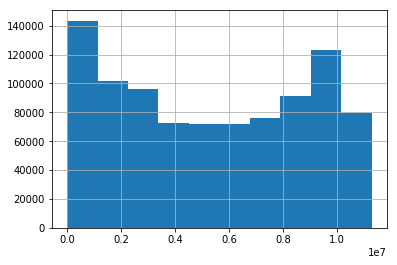

In [6]:
item_metadata['item_id'].hist()

## Extracting filters

In [0]:
# Treating them as independent... which is definitely not correct
# but anyway
filters_statistics = defaultdict(int)


for filters in train['current_filters'].dropna():
  for current_filter in filters.split('|'):
    filters_statistics[current_filter] += 1


In [8]:
filters = list(filters_statistics.keys())
filters[:10]

['Very Good Rating',
 '5 Star',
 '4 Star',
 'Hotel',
 'Motel',
 'Resort',
 'Hostal (ES)',
 '3 Star',
 'Best Value',
 'Free WiFi (Combined)']

## Creating tokenizers

In [0]:
class Tokenizer:
  """
  Mapping ids to ints.
  """
  
  def fit(self, data):
    self.vocabulary = set(data)
    self.mapping = dict(zip(self.vocabulary, range(1, len(self.vocabulary) + 1)))
    return self
    
  def transform(self, data):
    if isinstance(data, list):
      return [self.mapping.get(d, 0) for d in data]
    else:
      return self.mapping.get(data, 0) 

item_tokenizer = Tokenizer().fit(item_metadata['item_id'])
user_tokenizer = Tokenizer().fit(train['user_id'])
session_tokenizer = Tokenizer().fit(train['session_id'])

action_type_tokenizer = Tokenizer().fit(train['action_type'])
platform_tokenizer = Tokenizer().fit(train['platform'])
city_tokenizer = Tokenizer().fit(train['city'])
device_tokenizer = Tokenizer().fit(train['device'])
filters_tokenizer = Tokenizer().fit(filters)

tokenizers = {
  'item_id': item_tokenizer,
  'user_id': user_tokenizer,
  'session_id': session_tokenizer,
  'action_type': action_type_tokenizer,
  'platform': platform_tokenizer,
  'city': city_tokenizer,
  'device': device_tokenizer,
  'filters': filters_tokenizer
}

In [10]:
user_tokenizer.transform(['00RL8Z82B2Z1'])

[345341]

In [11]:
item_tokenizer.transform(666856)

339660

In [12]:
len(platform_tokenizer.vocabulary)

55

In [0]:
# These are actions that involve a particular item (except for clickout item)
ITEM_ACTIONS = [
 #'interaction item deals',
 'interaction item image',
 #'interaction item info',
 #'interaction item rating',
]

In [0]:
train_length = int(len(train) * 0.8)
train_split = train[:train_length]
val_split = train[train_length:]
len(train_split), len(val_split)
del train

## Dataset

В момента, ако имаме сесия с няколко clickouts: (A, B, C):
Начало ....... A.......B.....C........
Генераторът връща
- данните от началото до А
- данните от началото до B (с А)
- данните от началото до C (с A и B)
С ИЗКЛЮЧЕНИЕ, че след всеки clickout

In [0]:
class InputGenerator:
  all_fields = ['user_id', 'session_id', 'platform', 'city',
                'device','action_types', 'interacted_items',
                'filters', 'items', 'prices', 'timestamp']
  simple_fields = ['user_id', 'session_id', 'platform', 'city', 'device']
  
  def __init__(self, tokenizers, returned_fields=None):
    self.tokenizers = tokenizers
    self.returned_fields = returned_fields
    print(self.returned_fields)
    num_fields = len(returned_fields) if returned_fields else len(self.all_fields)
    self.output_types = tuple((tf.int32 for _ in range(num_fields)))
    self.padded_shapes = tuple([tf.TensorShape([None]) for _ in range(num_fields)])
    
    
  def prepare_last_row(self, row): 
    # Dealing with current_filters	impressions	prices
    impressions = list(map(int, row['impressions'].split('|')))
    items = self.tokenizers['item_id'].transform(impressions)
    prices = list(map(int, row['prices'].split('|')))
    clicked_item = self.tokenizers['item_id'].transform(int(row['reference']))

    return items, prices, clicked_item

  def input_generator_gen(self, df):
    def gen():
      last_step = None
      session_id = None
      
      for index, row in df.iterrows():
        user_id, new_session_id, platform, city, device = [self.tokenizers[field].transform(row[field]) for field in self.simple_fields]

        if session_id != new_session_id:
          # Reinitialize everything because a new session started.
          session_id = new_session_id
          action_types, interacted_items = [], []
          filters = set()
          last_step = 0
       
        last_step += 1
        # assert row['step'] == last_step
        
        if not pd.isnull(row['current_filters']):
          filters.update(self.tokenizers['filters'].transform(row['current_filters'].split('|')))

        if row['action_type'] in ITEM_ACTIONS and not pd.isnull(row['reference']):
          interacted_item = self.tokenizers['item_id'].transform(int(row['reference']))
          interacted_items.append(interacted_item)
        
        action_types.append(self.tokenizers['action_type'].transform(row['action_type']))

        # Checking if it is the last row from the session
        if row['action_type'] == 'clickout item':
          new_session = True
          items, prices, clicked_item = self.prepare_last_row(row)
          result = {
              'user_id': [user_id],
              'session_id': [session_id],
              'platform': [platform],
              'city': [city],
              'device': [device],
              'action_types': action_types,
              'interacted_items': interacted_items,
              'filters': list(filters),
              'items': items,
              'prices': prices,
              'timestamp': [row['timestamp']],
          }
          
          if self.returned_fields:
            returned_values = [result[f] for f in self.returned_fields]
          else:
            returned_values = result.values()
          
          yield tuple(returned_values), [clicked_item]
          interacted_items = []


    return gen, (self.output_types, tf.int32), (self.padded_shapes, tf.TensorShape([None]))
  
# input_user, input_platform, input_device, input_filters,
# input_interacted_items, input_impression_items


In [16]:
"""
i = InputGenerator(tokenizers,
                   returned_fields=['user_id', 'session_id', 'interacted_items'])
gen, types, shapes = i.input_generator_gen(train)
dataset = tf.data.Dataset.from_generator(gen, types)
dataset = dataset.take(20)
dataset = dataset.repeat().padded_batch(2, padded_shapes=shapes)
batch = dataset.make_one_shot_iterator().get_next()


with tf.Session() as sess:
  sess.run([tf.local_variables_initializer(), tf.tables_initializer()])
  b = sess.run(batch)
b
"""

"\ni = InputGenerator(tokenizers,\n                   returned_fields=['user_id', 'session_id', 'interacted_items'])\ngen, types, shapes = i.input_generator_gen(train)\ndataset = tf.data.Dataset.from_generator(gen, types)\ndataset = dataset.take(20)\ndataset = dataset.repeat().padded_batch(2, padded_shapes=shapes)\nbatch = dataset.make_one_shot_iterator().get_next()\n\n\nwith tf.Session() as sess:\n  sess.run([tf.local_variables_initializer(), tf.tables_initializer()])\n  b = sess.run(batch)\nb\n"

Малко промяна в модела:


*   по време на трениране, учим embedding на потребителя, който ще отразява цялата му активност, НО average на embeddings на items не правим върху всички такива, които е купувал някога (както в youtube са всики такива, които е гледал някога), а на тези, които са в impressions - мотивацията ми е, че тези items 1. приличат на target click_out item-a и 2. отговарят на действията/филтрите в сесията.
*   пак е един вид bag of actions, защото не ни интересува реда на actions, на сесии и тн., но просто сме групирали данните по сесии, учим по сесии.

input layer:
*   user embedding
*   ~session embedding~
*  ~action types~ 
* average of embeddings of the interacted with items (keeping the distribution! If the user has interacted twice with an item - summing it twice)
* average of embedding of the impression items
* filters - one-hot encoded, 1s at the used filters
*  platform - one-hot encoded
*  devices - one-hot encoded (is it worth it? are they even relevant...)
* any idea how to include the prices??? are they necessary? they are a property of the items in the end..



In [17]:
"""# TODO: work it out someway... BUG!
# https://github.com/keras-team/keras/issues/10472
class ReciprocalRank(tf.keras.callbacks.Callback):
    
    def __init__(self, dataset_val, batch_size = 20):
        super().__init__()
        it = dataset_val.make_one_shot_iterator().get_next()
        self.val_input_batch, self.val_target_items_batch = it
        self.batch_size = batch_size

    def on_train_begin(self, logs={}):
        self._data = []
        self.rrs = []

    def get_data(self):
        return self._data

    def on_epoch_end(self, batch, logs={}):
        predict = np.asarray(self.model.predict(x=self.val_input_batch,
                                                batch_size=self.batch_size,
                                                steps=1))
        #targ = sel.model.validation_data[1]
        self._data.append(predict)
        
custom_metrics = ReciprocalRank()"""

'# TODO: work it out someway... BUG!\n# https://github.com/keras-team/keras/issues/10472\nclass ReciprocalRank(tf.keras.callbacks.Callback):\n    \n    def __init__(self, dataset_val, batch_size = 20):\n        super().__init__()\n        it = dataset_val.make_one_shot_iterator().get_next()\n        self.val_input_batch, self.val_target_items_batch = it\n        self.batch_size = batch_size\n\n    def on_train_begin(self, logs={}):\n        self._data = []\n        self.rrs = []\n\n    def get_data(self):\n        return self._data\n\n    def on_epoch_end(self, batch, logs={}):\n        predict = np.asarray(self.model.predict(x=self.val_input_batch,\n                                                batch_size=self.batch_size,\n                                                steps=1))\n        #targ = sel.model.validation_data[1]\n        self._data.append(predict)\n        \ncustom_metrics = ReciprocalRank()'

In [0]:
class ReciprocalRankVal(tf.keras.callbacks.Callback):
    
    def __init__(self, dataset_val, batch_size = 20):
        super().__init__()
        it = dataset_val.make_one_shot_iterator().get_next()
        self.val_input_batch, self.val_target_items_batch = it
        self.batch_size = batch_size

    def on_train_begin(self, logs={}):
        self._data = []
        self.rrs = []

    def get_data(self):
        return self._data

    def on_epoch_end(self, batch, logs={}):
        predict = np.asarray(self.model.predict(x=self.val_input_batch,
                                                batch_size=self.batch_size,
                                                steps=1))
        #targ = sel.model.validation_data[1]
        self._data.append(predict)

In [19]:
params = {
    'users_embedding': 50,
    'users_vocab': len(tokenizers['user_id'].vocabulary),
    'items_embedding': 50,
    'items_vocab': len(tokenizers['item_id'].vocabulary),
    'platforms_vocab': len(tokenizers['platform'].vocabulary),
    'devices_vocab': len(tokenizers['device'].vocabulary),
    'filters_vocab': len(tokenizers['filters'].vocabulary),
    'layer_1_units': 400,
    'layer_2_units': 200,
    'layer_3_units': 100,
    'batch_size': 128
    
}
params

{'batch_size': 128,
 'devices_vocab': 3,
 'filters_vocab': 202,
 'items_embedding': 50,
 'items_vocab': 927142,
 'layer_1_units': 400,
 'layer_2_units': 200,
 'layer_3_units': 100,
 'platforms_vocab': 55,
 'users_embedding': 50,
 'users_vocab': 730803}

## Train and val datasets

In [24]:
# DATASET
batch_size = params['batch_size']
i = InputGenerator(tokenizers,
                  ['user_id', 'session_id', 'platform', 'device',
                   'interacted_items', 'filters', 'items', 'timestamp'])

def get_dataset_train():
  gen, types, shapes = i.input_generator_gen(train_split)
  dataset_train = tf.data.Dataset.from_generator(gen, types)
  dataset_train = dataset_train.repeat().padded_batch(batch_size,
                                                      padded_shapes=shapes)
  batch = dataset_train.make_one_shot_iterator().get_next()
  
  return batch

def get_dataset_eval():
  gen_val, types, shapes = i.input_generator_gen(val_split)
  dataset_val = tf.data.Dataset.from_generator(gen_val, types)
  dataset_val = dataset_val.padded_batch(batch_size,
                                         padded_shapes=shapes)
  batch_val = dataset_val.make_one_shot_iterator().get_next()
  
  return batch_val


steps_per_epoch = len(train_split) // batch_size
validation_steps = len(val_split) // batch_size
# These are not epochs but steps since we're using tf.dataset.


['user_id', 'session_id', 'platform', 'device', 'interacted_items', 'filters', 'items', 'timestamp']


## Defining the model

In [0]:
tf.logging.set_verbosity(tf.logging.INFO)

In [0]:
# Lambda wrappers
def expand_dims_axis(axis):
  def expand_dims(x):
    return tf.expand_dims(x, axis=axis)
  return expand_dims

def reduce_sum_axis(axis):
  def reduce_sum(x):
    return tf.reduce_sum(x, axis)
  return reduce_sum


def yt_rec_model_fn(
   features, # This is batch_features from input_fn
   labels,   # This is batch_labels from input_fn
   mode,     # An instance of tf.estimator.ModeKeys, see below
   params):  # Additional configuration

  batch_size = params['batch_size'] if mode in [TRAIN, EVAL] else 1

  # Input layers

  input_user, input_session, input_platform, input_device, \
  input_filters, input_interacted_items, \
  input_impression_items, input_timestamp = features


  users_embeddings = layers.Embedding(input_dim=params['users_vocab'],
                                      output_dim=params['users_embedding'])
  items_embeddings = layers.Embedding(input_dim=params['items_vocab'],
                                      output_dim=params['items_embedding'])

  input_user.set_shape([None, 1])
  input_platform.set_shape([None, 1])
  input_device.set_shape([None, 1])
  input_interacted_items.set_shape([batch_size, None])
  input_impression_items.set_shape([batch_size, None])

  user = users_embeddings(input_user)
  user.set_shape([None, 1, params['users_embedding']])
  user = tf.reshape(user, [-1, params['users_embedding']])

  platform = tf.one_hot(input_platform, params['platforms_vocab'])
  platform.set_shape([None, 1, params['platforms_vocab']])
  platform = tf.reshape(platform, [-1, params['platforms_vocab']])
  
  device = tf.one_hot(input_device, params['devices_vocab'])
  device.set_shape([None, 1, params['devices_vocab']])
  device = tf.reshape(device, [-1, params['devices_vocab']])
  # Summing them - taking into account all of the filters used.
  # TODO: FIX FILTERS
  # filters = tf.reduce_sum(tf.one_hot(input_filters, params['filters_vocab']), axis=0)

  interacted_items = items_embeddings(input_interacted_items)
  interacted_items.set_shape([None, None, params['items_embedding']])
  interacted_items = tf.reduce_mean(interacted_items, axis=1)
  
  impression_items = items_embeddings(input_impression_items)
  impression_items.set_shape([None, None, params['items_embedding']])
  impression_items = tf.reduce_mean(items_embeddings(input_impression_items), axis=1)


  whole_size = params['users_embedding'] + params['platforms_vocab'] + params['devices_vocab'] + 2 * params['items_embedding'] # +  params['filters_vocab']
  # 100 + 50 + 55 + 3 + 202

  tf.logging.info(whole_size)

  # Dense layers
  input_layer = tf.concat([user, platform, device, # filters,
                          interacted_items, impression_items],
                          axis=1)
  #input_layer.set_shape([None, whole_size]) 
  first_layer = layers.Dense(units=params['layer_1_units'],
                             activation=tf.keras.activations.relu)(input_layer)
  second_layer = layers.Dense(units=params['layer_2_units'],
                              activation=tf.keras.activations.relu)(first_layer)
  third_layer = layers.Dense(units=params['layer_3_units'],
                             activation=tf.keras.activations.relu)(second_layer)
  
  last_layer_w = W1 = tf.Variable(tf.random_normal([params['layer_3_units'],
                                                    params['items_vocab']]))
  last_layer_b = tf.Variable(tf.random_normal([params['items_vocab']]))
  
  
  logits = tf.matmul(third_layer, last_layer_w) + last_layer_b

  tf.logging.info('HELLO')
  if mode in [tf.estimator.ModeKeys.TRAIN, tf.estimator.ModeKeys.EVAL]:
      # Calculate Loss (for both TRAIN and EVAL modes)
    # I guess the samples not enough to train the model...
    # The loss does not change.
    #loss = tf.nn.sampled_softmax_loss(labels=labels,
    #                                  inputs=third_layer,
    #                                  weights=tf.transpose(last_layer_w),
    #                                  biases=last_layer_b,
    #                                  num_sampled=90_000, # 10%
    #                                  num_classes=params['items_vocab'])
    
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels,
                                          logits=logits)
    loss = tf.reduce_mean(loss)

  
  if mode == tf.estimator.ModeKeys.TRAIN:
    tf.summary.scalar('loss-train', tf.reduce_sum(loss))
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
    train_op = optimizer.minimize(
        loss=loss,
        global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

  
  mask_impressions = tf.reduce_sum(tf.one_hot(input_impression_items, params['items_vocab']), axis=1)
  #predictions = tf.multiply(mask_impressions, last_layer)
  predictions = layers.Softmax()(logits)
  predicted_classes = tf.argmax(predictions, 1)


  if mode == tf.estimator.ModeKeys.PREDICT:
    predictions = {
        'class_ids': predicted_classes,
        'probabilities': predictions,
        'user_id': input_user,
        'session_id': input_session,
        'timestamp': input_timestamp
    }
    return tf.estimator.EstimatorSpec(mode, predictions=predictions)


  # Add evaluation metrics (for EVAL mode)
  eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predicted_classes)}
  return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [0]:
run_config = tf.estimator.RunConfig(log_step_count_steps=30,
                                    # save_summary_steps=20,
                                    save_checkpoints_steps=10000,
                                    keep_checkpoint_max=1)

yt_estimator = tf.estimator.Estimator(
  model_fn=yt_rec_model_fn,
  model_dir='./best_model_yt',
  params=params,
  config=run_config
)

train_spec = tf.estimator.TrainSpec(input_fn=get_dataset_train,
                                    max_steps=1 * steps_per_epoch)
# throttle_secs=10 lol
eval_spec = tf.estimator.EvalSpec(input_fn=get_dataset_eval,
                                  throttle_secs=30)

tf.estimator.train_and_evaluate(yt_estimator, train_spec, eval_spec)

I0623 20:18:16.660300 139695598520192 estimator.py:209] Using config: {'_model_dir': './best_model_yt', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 10000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 1, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 30, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f0cbe10f6a0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
I0623 20:18:16.663259 139695598520192 estimator_training.py:186] Not using Distribute Coordina

In [0]:
from google.colab import files

#!tar -cvf best_model.tar best_model
#files.download('best_model/model.ckpt-7100.data-00000-of-00001')

#uploaded = drive.CreateFile({'title': 'best_model'})
#uploaded.SetContentFile('/content/drive/My Drive/recsys/best_model.tar')
#uploaded.Upload()
#print('Uploaded file with ID {}'.format(uploaded.get('id')))


In [0]:
#!rm -r best_model
#!rm -r /tmp

https://stackoverflow.com/questions/47676248/accessing-validation-data-within-a-custom-callback


~Use Keras [callbacks](https://github.com/keras-team/keras/issues/5794) instead of a custom metric?~ Outdated. Using tf.Estimator now.

## Generating predictions

In [0]:
del train_split
del val_split

In [0]:
test = pd.read_csv(os.path.join(PATH, 'test.csv'))
test = test[test['action_type'] == 'clickout item']
test = test[test['reference'].isnull()]
test['reference'].fillna(0, inplace=True)
#test_all['reference'].fillna(0, inplace=True)
# TODO: Use all of the test rows!!!

In [0]:
inputgen_test = InputGenerator(tokenizers,
                  ['user_id', 'session_id', 'platform', 'device',
                   'interacted_items', 'filters', 'items', 'timestamp'])

same_keys = ['user_id', 'session_id', 'timestamp', 'step']

def get_dataset_test():
  gen_test, types, shapes = inputgen_test.input_generator_gen(test)
  dataset = tf.data.Dataset.from_generator(gen_test, types).padded_batch(500, shapes)
  batch_val = dataset.make_one_shot_iterator().get_next()
  
  return dataset

inv_map = {(v - 1): k for k, v in item_tokenizer.mapping.items()}


yt_rec_estimator = tf.estimator.Estimator(
  model_fn=yt_rec_model_fn,
  model_dir='./yt-7100',
  params=params,
  #config=run_config
)


In [0]:
def save_preds(filename, l_results):
  r = pd.DataFrame(l_results)
  r.to_csv(filename)
  del r
  uploaded = drive.CreateFile({'title': filename})
  uploaded.SetContentFile(os.path.join('/content/drive/My Drive/recsys/',
                                       filename))
  uploaded.Upload()
  print('Uploaded file with ID {}'.format(uploaded.get('id')))

In [0]:
all_count = len(test)
results = []
predictions = yt_rec_estimator.predict(input_fn=get_dataset_test)
test_iter = test.iterrows()
counter = 0
print('All rows: {}'.format(all_count))

In [0]:
for (index, row), prediction in zip(test_iter, predictions):
  result_row = {}
  for r in same_keys:
    result_row[r] = row[r]
  
  assert row['timestamp'] ==  prediction['timestamp']
  impressions = list(map(int, row['impressions'].split('|')))
  k = len(impressions)
  items = item_tokenizer.transform(impressions)

  mask = np.zeros((len(items), len(item_tokenizer.vocabulary)))
  mask[np.arange(len(items)), items] = 1
  mask = mask.sum(axis=0)
  
  scores = np.multiply(mask, prediction['probabilities'])
  indices = scores.argsort()[-k:][::-1]

  item_recommendations = []
  for i in indices:
    item_recommendations.append(inv_map[i])
  
  item_recommendations = map(str, item_recommendations)
  result_row['item_recommendations'] = ' '.join(item_recommendations)
  
  results.append(result_row)
  counter += 1

  if counter % 1000 == 0:
    print(counter/all_count)
    print('PREDICTIONS: {}'.format(counter))
    
  if counter % 50_000 == 0:
    print(counter/all_count)
    print('PREDICTIONS: {}'.format(counter))
    save_preds('results2/predictions-{}.csv'.format(counter), results)
    del results
    results = []

In [0]:
save_preds('results2/predictions-{}.csv'.format(counter), results)